In [59]:
from keras.models import Sequential
from keras.layers.core import Dense
import theano
import numpy as np

import sys
sys.path.insert(0, '/home/flipvanrijn/Workspace/Dedicon-Thesis/')

In [340]:
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

###Setup data###

In [61]:
from networks.keras.sentembed import SentEmbed

emb = SentEmbed('/home/flipvanrijn/Workspace/Dedicon-Thesis/downloads/coco_train_dataset.json')

In [242]:
# Load a sentence
sentence = emb.sentences[0]
sentence_1h = np.array(emb.sentence_to_1h(sentence))
sentence_1h = sentence_1h[:, np.newaxis, :]
print sentence, sentence_1h

[u'a', u'restaurant', u'has', u'modern', u'wooden', u'tables', u'and', u'chairs', u'.'] [[[ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]]]


In [313]:
# Load image
import hdf5storage
image_data = hdf5storage.read(path='/', filename='/home/flipvanrijn/Workspace/Dedicon-Thesis/output/chairs.mat')
image_feats = image_data[0][0][0][0]     # 4096 features from CNN
image_fragments = image_data[0][0][0][1] # regions in image

###Experimenting with embedding image regions###

In [249]:
image_model = Sequential()
image_model.add(Dense(4096, 500, init='uniform'))

In [341]:
f_image = theano.function([image_model.get_input(train=False)], image_model.get_output(train=False))
img_output = f_image(image_feats) # CNN input w/ shape (nb_regions, nb_features)
img_output.shape

(20, 500)

(4096, 500) (500,)


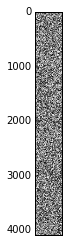

In [368]:
print image_model.layers[0].W.get_value().shape, image_model.layers[0].b.get_value().shape
fig, ax = plt.subplots()
ax.xaxis.set_visible(False)
ax.imshow(image_model.layers[0].W.get_value())

###Experimenting with embedding sentence

In [364]:
from networks.keras.birnn import BiDirectionLSTM
sent_model = Sequential()
sent_model.add(BiDirectionLSTM(8856, 500, activation='relu', output_mode='sum'))
f_sent = theano.function([sent_model.get_input(train=False)], sent_model.get_output(train=False))

In [365]:
sentence_1h.shape
sent_output = f_sent(sentence_1h)
sent_output.shape

(9, 1, 500)

###No training: v<sub>i</sub>*s<sub>t</sub>###

S_kl = 672.732543945


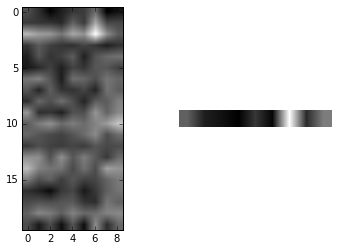

In [363]:
nb_img_fragments = img_output.shape[0]
nb_sent_fragments = sent_output.shape[0]
scores = np.empty((nb_img_fragments, nb_sent_fragments), dtype=np.float32)
for t in xrange(nb_sent_fragments):
    for i in xrange(nb_img_fragments):
        img = img_output[i]
        sent = sent_output[t]
        scores[i][t] = np.dot(img, np.squeeze(sent))
max_scores = np.amax(scores, axis=0)[np.newaxis, :]
plt.gray()
fig_feats, ax_feats = plt.subplots(1, 2)
ax_feats[0].imshow(scores)
ax_feats[1].imshow(max_scores)
ax_feats[1].axis('off')
idx_fragment = np.argmax(scores, axis=0)
print 'S_kl = {}'.format(np.sum(max_scores))

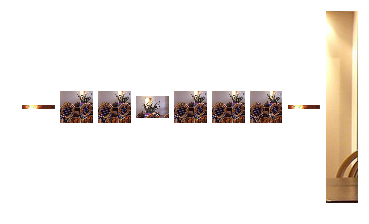

In [354]:
fig_fragments, ax_fragments = plt.subplots(1, len(idx_fragment))
for i, idx in enumerate(idx_fragment):
    ax_fragments[i].imshow(image_fragments[idx])
    ax_fragments[i].axis('off')